In [1]:
import pandas as pd
from math import log
import numpy as np
import pickle

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib


from scipy.spatial.distance import cdist


from functools import reduce
from operator import add

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data needed:
## cRPKMs

We load previously computed cRPKMs into a dataframe.
Each row is a gene (the rows are indexed by geneID) and each column is an experiment/tissue/stage.

In [13]:
def load_crpkms(fp, css=None):
    crpkms = pd.read_csv(fp, sep='\t').fillna(0)
    crpkms.drop("NAME", axis=1, inplace=True)
    crpkms = crpkms.set_index('ID')
    crpkms = crpkms.applymap(lambda x: log(x+1,10))
    # if you want to filter the columns at this stage
    if css:
        crpkms = crpkms.loc[:,css]
    # remove any column with 0 variance
    crpkms = crpkms[crpkms.std(axis=1)>0]   
    return crpkms

# as an example of what this table should look like,
# this is the top of our human set:
load_crpkms("/path/to/cRPKM-Hsa52.tab").head()

,Adipose_Breast,Adrenal,Amnion,Brain,Brain_Cortex_M,Brain_FrGyrus_o,Brain_FrGyrus_y,Brain_STG,Cerebellum_M,Chorion,...,Placenta,PlacentaEpiC_M,PREC_HFDPC,PREC_MSCab,PREC_NPC_cont,PREC_NPC_f,Prostate,Testis_M,Thyroid,WBC_MC
ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1.577377,1.131298,1.191451,1.066326,1.071514,0.922206,1.141763,0.646404,0.814248,0.946452,...,1.192289,1.515476,1.131939,1.236285,1.583312,1.494850,1.454540,1.606811,1.506640,0.474216
ENSG00000000005,1.545060,0.899273,0.000000,0.053078,0.037426,0.230449,0.170262,0.049218,0.012837,0.149219,...,0.110590,0.017033,0.411620,0.004321,0.000000,0.004321,0.176091,0.190332,0.086360,0.000000
ENSG00000000419,1.430398,1.580811,1.242044,1.492900,0.899821,1.702603,1.765892,1.188084,1.082067,1.160469,...,1.442793,1.297323,1.156549,1.333044,1.392169,1.347720,1.592510,1.616895,1.715669,1.552911
ENSG00000000457,0.598791,0.765669,0.633468,0.610660,0.354108,0.595496,0.663701,0.361728,0.710117,0.503791,...,0.824776,1.033826,0.812245,0.846337,0.724276,0.806180,0.854913,0.741152,0.781037,0.793092
ENSG00000000460,0.356026,0.371068,0.354108,0.195900,0.227887,0.474216,0.522444,0.161368,0.583199,0.267172,...,0.528917,0.696356,0.408240,0.472756,0.704151,0.671173,0.440909,1.001734,0.357935,0.394452


## Gene families:

We have in our disposal a precomputed table where genes of various species
are separated into homologous families.

Each row is a family, each column a species. 
The paralogues of each species are separated with ":" so when we load this dataset
we split the strings into lists.

We also create a second dataframe "gfamsC" which has the same index and shape as the first one,
but contains the count of genes in each cell.

In [19]:
gfams = (pd
            .read_csv("/path/to/genefams.tab",
                     sep='\t')
            .applymap(lambda c: c.split(':') if c==c else []))

gfams.loc[:,['Hsa','Bla','Dre','Ola']].head()

,Hsa,Bla,Dre,Ola
0,[],[BL61971],[],[]
1,[],[BL20829],[],[]
2,[],[BL20827],[],[]
3,"[ENSG00000095110, ENSG00000137634, ENSG0000014...","[BL19024, BL01477, BL01313, BL23721, BL56097, ...","[ENSDARG00000092898, ENSDARG00000095333, ENSDA...","[ENSORLG00000009799, ENSORLG00000000508, ENSOR..."
4,[],[BL09206],[],[]


In [20]:
gfamsC = gfams.applymap(lambda c: len(c))
gfamsC.loc[:,['Hsa','Bla','Dre','Ola']].head()

,Hsa,Bla,Dre,Ola
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,4,36,9,3
4,0,1,0,0


We will use the gene families tables to load orthologous genes from two species,
Human which is our reference species and species2

In [47]:
def get_sets(spec2):
    # get the 1-1 genes
    # get genes where there's only one paralogue in both Human and "species2"
    foo = gfams.loc[(gfamsC.Hsa==1) & (gfamsC[spec2]==1),['Hsa',spec2]].copy()
    foo = foo.applymap(lambda x: x[0])
    foo = foo[~foo[spec2].duplicated(keep=False)]
    assert len(foo.Hsa) == len(set(foo.Hsa.values)) == len(foo[spec2]) == len(set(foo[spec2].values))
    # Get the 1-1 genes in two separate arrays
    # one for human and the other for species2
    oto1 = foo.Hsa.values
    oto2 = foo[spec2].values
    # Then we get the X-Y genes
    # where there's at least one paralogue in human
    # and at least one in species 2
    foo = gfams.loc[(gfamsC.Hsa>0) & (gfamsC[spec2]>0),['Hsa',spec2]].copy()
    # The X-Y genes will be stored in sets instead of arrays
    multi1 = set(reduce(add, foo.Hsa))
    multi2 = set(reduce(add, foo[spec2]))
    return oto1,oto2,multi1,multi2

def get_distance_tables(rpkms, set1,set2, metric):    
    # XB is the crpkms of the genes that are 1-1 between human and species2
    XB = rpkms.loc[set1,:].copy().fillna(0.0)
    # XA is the crpkms of the genes that are X-Y between human and species2
    XA = rpkms.loc[set2,:].copy().fillna(0.0)
    
    # cdist takes two tables (XA and XB)
    # and calculates the euclidean distance between every row of XA and every
    # row of XB
    # consequently the resulting table has
    # rows: as many rows as XA has
    # columns: as many rows as XB has
    # This is a VERY fast way to do this, don't try calculating the distances manually
    res = pd.DataFrame(cdist(XA,XB, metric))
    # We have computed the distance of all X-Y genes to all 1-1 genes
    res.columns = XB.index
    res.index = XA.index
    del XA,XB
    res = res.reindex(index=list(res.columns) + list(res.index.difference(res.columns))) 
    
    # The diagonal of this matrix is 0 since, of course,
    # genes are identical to themselves
    # We fill the diagonal with the max value found in the table
    fillval = res.max().max() + 0.01
    np.fill_diagonal(res.values, fillval)
    res = res.fillna(fillval)
    
    # Finally we have a table with the distance of all X-Y genes (rows)
    # to all 1-1 genes (columns)
    return res

def yield_gene_combos(spec2):
    
    # The final distribution of NACC values will be calculated 
    # for a subset of genes.
    # Those genes belong in families where there is :
    # only one Amphioxus paralogue
    # at least one human paralogue but at most 4 human paralogues
    # at least one paralogue in species 2 but at most 8
    foo = gfams.loc[(gfamsC.Bla==1) & (gfamsC.Hsa>0) & (gfamsC[spec2]>0) & (gfamsC.Hsa<=4) & (gfamsC[spec2]<=8),
                    ['Hsa',spec2]]
    
    # we yield those genes, a NACC value will be calculated per pair of genes
    for irow,row in foo.iterrows():
        for hsagene in row.Hsa:
            yield hsagene, row[spec2]

def get_naccs(spec2, fp2):
    
    # We used human as a reference species, so species1 would always
    # be the same:
    fp1 = "/home/ska/panos/boxes/a_newNACC/data/cRPKM-Hsa52.tab"
    
    metric = 'euclidean'

    # load the crpkms for the 2 species, and do some preprocessing
    crpkms1 = load_crpkms(fp1)
    crpkms2 = load_crpkms(fp2)
    
    # get the 1-1 and X-Y genes between human and species 2
    oto1,oto2,multi1,multi2 = get_sets(spec2)
    assert len(oto1) == len(set(oto1)) == len(oto2) == len(set(oto2))
    
    # in each species, get the distances of all X-Y genes to all 1-1 genes
    res1 = get_distance_tables( crpkms1, oto1, multi1, metric)
    res2 = get_distance_tables( crpkms2, oto2, multi2, metric)
    
    # a dictionary that maps the 1-1 genes between the two species
    otod = dict(zip(oto1,oto2))
    otod.update(dict(zip(oto2,oto1)))
    
    # The 1-1 dictionary shuffled, for the control distribution
    oto1R = np.random.permutation(oto1)
    oto2R = np.random.permutation(oto2)
    otodR = dict(zip(oto1R,oto2R))
    otodR.update(dict(zip(oto2R,oto1R)))
    
    # List of NACCvalues
    lon = []
    # List of NACCvalues_randomized
    lon_r = []
    
    # yield_gene_combos yields tuples of :
    # (human_gene, [list of species 2 genes])
    for g1,listog in yield_gene_combos(spec2):
        
        # get the neighborhood of g1, the human paralogue
        # the neighborhood is selected from the columns of the res table
        # those are the 1-1 genes
        # That's because we need to be able to get an exact 1-1 mapping
        # of the neighborhood genes to the other species
        # if we selected neighborhood genes from the X-Y gene set,
        # each neighborhood gene would have multiple possible orthologous genes in the
        # other species, makibng the mapping impossible.
        g1neigh = res1.loc[g1,:].sort_values(ascending=True)[:20].index.values
        # Now we get the orthologous genes of the neighborhood genes
        g1neighT = [otod[x] for x in g1neigh]
        # and again, but this time from the shuffled dictionary for control
        g1neighTR = [otodR[x] for x in g1neigh]
        
        for g2 in listog:  
            # the neighborhood genes of species 2
            g2neigh = res2.loc[g2,:].sort_values(ascending=True)[:20].index.values
            # the human orthologues of the neighborhood_species2 genes
            g2neighT = [otod[x] for x in g2neigh]
            # randomly
            g2neighTR = [otodR[x] for x in g2neigh]
            
            # the NACC value for g1 - g2
            # res2.loc[g2,g1neighT] <-- the distances of g2 to the orthologous
            # genes of the neighborhood genes
            # res1.loc[g1,g2neighT] <-- The same thing, but with the species flipped
            nacc = (res2.loc[g2,g1neighT] - res1.loc[g1,g2neighT].values).abs().mean()
            nacc_r = (res2.loc[g2,g1neighTR] - res1.loc[g1,g2neighTR].values).abs().mean()
            
            # append the values in the lists
            lon.append(nacc)
            lon_r.append(nacc_r)
    return lon, lon_r


In [49]:
# get the NACC values for a species
lon_bla, lonr_bla = get_naccs('Bla', "/path/to/Bla_samples.tab")

In [40]:
len(lon_bla),len(lonr_bla)

(8633, 8633)

## Plotting the distribution

In [44]:
sns.set_style('white')
histogram_bins = np.linspace(0,8,100)

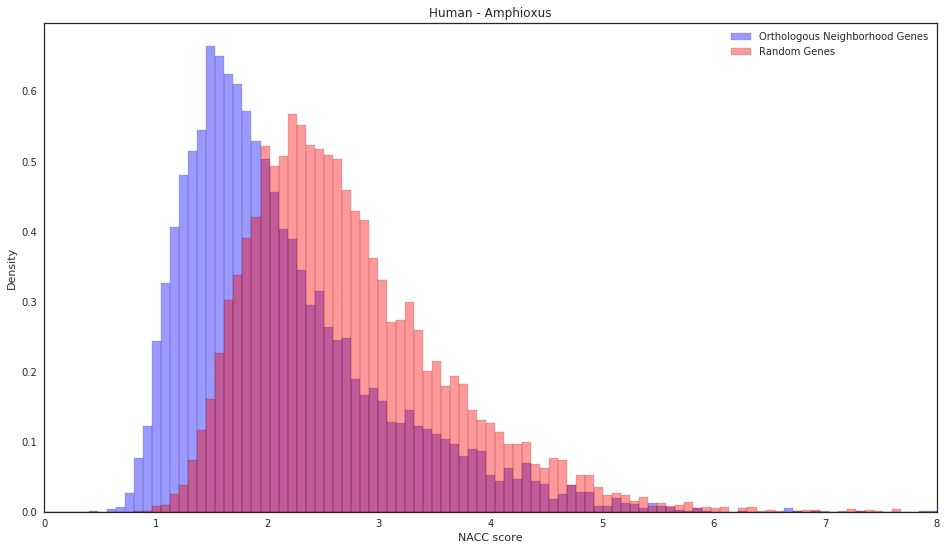

In [45]:
plt.figure(figsize=(16,9))

sns.distplot(lon_bla, 
             kde=False,  
             color='blue',
             bins=histogram_bins,
             norm_hist = True, 
             hist_kws={'edgecolor':'black'},
             label="Orthologous Neighborhood Genes")

sns.distplot(lonr_bla,
             kde=False,
             color='red',
             bins=histogram_bins,
             norm_hist = True,
             hist_kws={'edgecolor':'black'},
             label="Random Genes")

plt.xlim((0,8))
plt.ylabel("Density")
plt.xlabel("NACC score")
plt.title("Human - Amphioxus")
plt.legend()

If we get the distributions for more than one species, we can combine all of them into one plot:

In [19]:
df_mmu = pd.concat([pd.melt(pd.DataFrame(lon_mmu, columns=['nacc'])), pd.melt(pd.DataFrame(lonr_mmu, columns=['nacc_r']))])
df_mmu['species'] = 'mmu'
df_bla = pd.concat([pd.melt(pd.DataFrame(lon_bla, columns=['nacc'])), pd.melt(pd.DataFrame(lonr_bla, columns=['nacc_r']))])
df_bla['species'] = 'bla'
df_dre = pd.concat([pd.melt(pd.DataFrame(lon_dre, columns=['nacc'])), pd.melt(pd.DataFrame(lonr_dre, columns=['nacc_r']))])
df_dre['species'] = 'dre'

biggy = pd.concat([df_bla, df_mmu, df_dre])

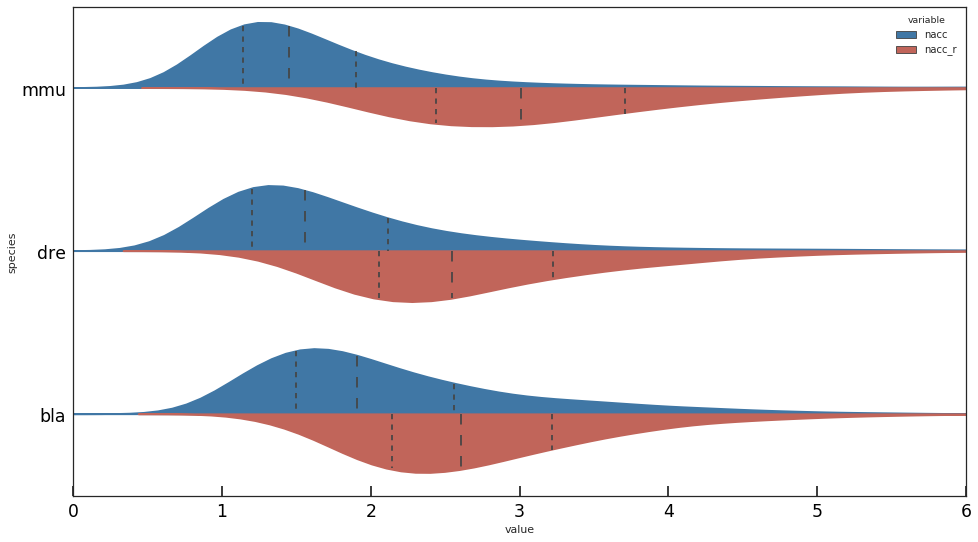

In [34]:
# With some tissues for bla

fig, ax = plt.subplots(figsize=(16,9))


sns.violinplot(data=biggy, y = 'species', hue='variable', x='value', split=True,
               
              order = ['mmu','dre','bla'], scale_hue=True, bw=0.25,
              inner= "quartile", 
               palette={'nacc':(0.1843137254901961, 0.47266435986159167, 0.7116493656286044),
                        'nacc_r':(0.8226066897347174, 0.34325259515570933, 0.28627450980392155)
                        },
               ax=ax               
              )

ax.tick_params(direction ='in',
               length=10, width=1.5, colors='black',labelsize='x-large')


plt.xlim((0,6))